In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate# GridSearchCV já está importado
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel # Mantenha se for usar, senão pode remover
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


# Leitura dos arquivos

In [4]:
df = pd.read_csv('df_treino_final_para_modelo.csv', low_memory=False)

In [5]:
porcentagem_nulos = df.isnull().mean() * 100
colunas_para_remover = porcentagem_nulos[porcentagem_nulos > 30].index
df = df.drop(columns=colunas_para_remover)
print(f"Restaram {df.shape[1]} colunas após remoção de ausentes.")


Restaram 11 colunas após remoção de ausentes.


In [6]:
print("\n--- df info ---")
print(df.info())


--- df info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931299 entries, 0 to 931298
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   FORMA       931111 non-null  float64
 1   CS_SEXO     931299 non-null  object 
 2   CS_RACA     921714 non-null  object 
 3   NU_IDADE_N  931096 non-null  float64
 4   HIV         929546 non-null  object 
 5   AGRAVAIDS   922211 non-null  float64
 6   AGRAVALCOO  922687 non-null  float64
 7   RAIOX_TORA  921472 non-null  object 
 8   BACILOSC_E  931133 non-null  object 
 9   CULTURA_ES  931133 non-null  object 
 10  NU_ANO      931299 non-null  int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 78.2+ MB
None


In [7]:
print("\nPrimeiras linhas df:")
print(df.head())


Primeiras linhas df:
   FORMA CS_SEXO   CS_RACA  NU_IDADE_N            HIV  AGRAVAIDS  AGRAVALCOO  \
0    1.0       F     Parda      4011.0  Não realizado        2.0         2.0   
1    1.0       M  Indígena      4046.0   Não Reagente        2.0         2.0   
2    1.0       F     Parda      4065.0  Não realizado        2.0         1.0   
3    1.0       M    Branca      4059.0   Não Reagente        2.0         1.0   
4    1.0       M     Parda      4035.0   Não Reagente        2.0         2.0   

  RAIOX_TORA BACILOSC_E CULTURA_ES  NU_ANO  
0        1.0        1.0        4.0    2020  
1        4.0        1.0        4.0    2020  
2        1.0        1.0        4.0    2020  
3        1.0        3.0        2.0    2020  
4        1.0        1.0        4.0    2021  


In [8]:
print("\nContagem de 'FORMA' no df:")
print(df['FORMA'].value_counts())


Contagem de 'FORMA' no df:
FORMA
1.0    429028
4.0    429028
2.0     56767
3.0     16288
Name: count, dtype: int64


In [9]:
df['FORMA'] = df['FORMA'].astype(str)

# fim da leitura de dados

In [10]:
# --- Seleção de Colunas para o Modelo ---
colunas_modelo = [
    'FORMA',            # variável alvo
    'CS_SEXO',
    'CS_RACA',
    'NU_IDADE_N',
    'HIV',
    'AGRAVAIDS',
    'AGRAVALCOO',
    'RAIOX_TORA',
    'BACILOSC_E',
    'CULTURA_ES',
    'NU_ANO'            # ano da notificação
]
df_modelo = df[colunas_modelo].copy()


# --- Conversão da coluna NU_IDADE_N ---

In [11]:
def converter_idade_para_modelo(nu_idade_n):
    if pd.isna(nu_idade_n) or int(nu_idade_n) == 0: # Trata NaNs ou 0000 como idade ignorada
        return np.nan # Retorna np.nan para ser imputado posteriormente

    nu_idade_n = int(nu_idade_n) # Garante que é inteiro para as operações
    unidade = nu_idade_n // 1000
    valor = nu_idade_n % 1000

    if unidade == 1:  # Horas
        return valor / (24 * 365)
    elif unidade == 2:  # Dias
        return valor / 365
    elif unidade == 3:  # Meses
        return valor / 12
    elif unidade == 4:  # Anos
        return valor
    else: # Idade ignorada ou inválida (ex: '0000')
        return np.nan

In [12]:
# Aplica a função para criar a coluna de idade em anos correta
df_modelo['NU_IDADE_ANOS_CORRETA'] = df_modelo['NU_IDADE_N'].apply(converter_idade_para_modelo)


In [13]:
# Preencher NaNs na nova coluna de idade (se houver, após a conversão) com a mediana
mediana_idade_correta = df_modelo['NU_IDADE_ANOS_CORRETA'].median()
df_modelo['NU_IDADE_ANOS_CORRETA'] = df_modelo['NU_IDADE_ANOS_CORRETA'].fillna(mediana_idade_correta)


In [14]:
# Criar Faixa Etária a partir da idade correta
bins = [0, 18, 35, 50, 65, 120]
labels = ['Jovem', 'Adulto Jovem', 'Adulto', 'Idoso', 'Muito Idoso']
df_modelo['faixa_etaria'] = pd.cut(df_modelo['NU_IDADE_ANOS_CORRETA'], bins=bins, labels=labels, right=False, include_lowest=True)


In [15]:
# 2. Criar um contador de comorbidades/fatores de risco
# Garantir que AGRAVAIDS e AGRAVALCOO sejam numéricos antes de operar
df_modelo['AGRAVAIDS'] = pd.to_numeric(df_modelo['AGRAVAIDS'], errors='coerce').fillna(0.0)
df_modelo['AGRAVALCOO'] = pd.to_numeric(df_modelo['AGRAVALCOO'], errors='coerce').fillna(0.0)
df_modelo['total_comorbidades'] = (df_modelo['AGRAVAIDS'] == 1.0).astype(int) + \
                                  (df_modelo['AGRAVALCOO'] == 1.0).astype(int)


In [16]:
# 3. Criar feature de interação para HIV com AIDS
# Preencher NaNs antes da comparação para 'HIV'
df_modelo['HIV'] = df_modelo['HIV'].fillna('Não Informado')

df_modelo['hiv_positivo_com_aids'] = ((df_modelo['HIV'] == 'Reagente') & (df_modelo['AGRAVAIDS'] == 1.0))

# Remover colunas originais que foram transformadas/substituídas
df_modelo = df_modelo.drop(columns=['NU_IDADE_N', 'AGRAVAIDS', 'AGRAVALCOO'])


In [17]:
# Garantir que a coluna FORMA é float para poder adicionar 4.0
df_modelo['FORMA'] = df_modelo['FORMA'].fillna(0).astype(float) # Preenche NaNs com 0 e converte para float


In [18]:
print(f"Número de linhas em df_modelo antes da filtragem de FORMA=0.0: {len(df_modelo)}")
df_modelo = df_modelo[df_modelo['FORMA'] != 0.0].copy() # Filtra as linhas onde FORMA é 0.0
print(f"Número de linhas em df_modelo após a filtragem de FORMA=0.0: {len(df_modelo)}")


Número de linhas em df_modelo antes da filtragem de FORMA=0.0: 931299
Número de linhas em df_modelo após a filtragem de FORMA=0.0: 931299


# --- Preparação dos Dados para o Modelo ---

In [19]:
# Preencher NaNs da FORMA com a moda antes de converter e codificar.
# Isso garante que não haverá IntCastingNaNError.
# A moda é uma boa escolha para variáveis categóricas/discretas como 'FORMA'.
df_modelo['FORMA'] = df_modelo['FORMA'].fillna(df_modelo['FORMA'].mode()[0])

In [20]:
# Preencher NaNs da FORMA com a moda antes de converter para int (se houver)
#df_modelo['FORMA'] = df_modelo['FORMA'].fillna(df_modelo['FORMA'].mode()[0])
y = df_modelo['FORMA'].astype(int)
X = df_modelo.drop('FORMA', axis=1)


In [21]:
# ---- Codificar a variável alvo 'FORMA' para 0, 1, 2 ----
le = LabelEncoder()
y = le.fit_transform(df_modelo['FORMA'].astype(int)) # y agora será 0, 1, 2
#X = df_modelo.drop('FORMA', axis=1)

In [22]:
mapeamento_nomes_descritivos = {
    1.0: "Pulmonar",
    2.0: "Extrapulmonar",
    3.0: "Mista",
    4.0: "Saudável"
}
encoded_to_descriptive_name_map = {}
for i, original_label_str in enumerate(le.classes_):
    original_id_float = float(original_label_str)
    if original_id_float in mapeamento_nomes_descritivos:
        encoded_to_descriptive_name_map[i] = mapeamento_nomes_descritivos[original_id_float]
    else:
        print(f"Aviso: Classe {original_id_float} do LabelEncoder não encontrada no mapeamento descritivo.")


In [23]:
# Split dos dados em treino e teste - ISSO DEVE SER FEITO AQUI!
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.02, stratify=y, random_state=42)
#Dividir os 2% restantes em 1% para validação e 1% para teste (0.5 de 2% é 1%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Divisão de dados 98/1/1 (Treino/Validação/Teste) concluída.")
print(f"Shape de X_train: {X_train.shape}, Shape de y_train: {y_train.shape}")
print(f"Shape de X_val: {X_val.shape}, Shape de y_val: {y_val.shape}")
print(f"Shape de X_test: {X_test.shape}, Shape de y_test: {y_test.shape}")

# Preparar y_test_nomes para avaliação final (antes de usar y_test no GridSearchCV)
#y_test_nomes = [encoded_to_descriptive_name_map[t] for t in y_test]

Divisão de dados 98/1/1 (Treino/Validação/Teste) concluída.
Shape de X_train: (912673, 11), Shape de y_train: (912673,)
Shape de X_val: (9313, 11), Shape de y_val: (9313,)
Shape de X_test: (9313, 11), Shape de y_test: (9313,)


In [24]:
print("\nDistribuição das classes nos splits:")
splits = {'Treino': y_train, 'Validação': y_val, 'Teste': y_test}
for name, y_split in splits.items():
    print(f"--- {name} ---")
    unique, counts = np.unique(y_split, return_counts=True)
    for label_num, count in zip(unique, counts):
        label_orig = le.inverse_transform([label_num])[0]
        print(f"Classe {label_orig} ({label_num}): {count} amostras ({count/len(y_split):.2%})")



Distribuição das classes nos splits:
--- Treino ---
Classe 1 (0): 420632 amostras (46.09%)
Classe 2 (1): 55632 amostras (6.10%)
Classe 3 (2): 15962 amostras (1.75%)
Classe 4 (3): 420447 amostras (46.07%)
--- Validação ---
Classe 1 (0): 4292 amostras (46.09%)
Classe 2 (1): 567 amostras (6.09%)
Classe 3 (2): 163 amostras (1.75%)
Classe 4 (3): 4291 amostras (46.08%)
--- Teste ---
Classe 1 (0): 4292 amostras (46.09%)
Classe 2 (1): 568 amostras (6.10%)
Classe 3 (2): 163 amostras (1.75%)
Classe 4 (3): 4290 amostras (46.06%)


In [25]:
# Identificar colunas numéricas e categóricas (APÓS a engenharia de features)

numeric_features = ['NU_ANO', 'NU_IDADE_ANOS_CORRETA', 'total_comorbidades']

# Adicione as colunas que você identificou como categóricas/ordinais
categorical_features = [
    'CS_SEXO', 'CS_RACA', 'HIV', 'faixa_etaria', 'hiv_positivo_com_aids',
    'RAIOX_TORA', 'BACILOSC_E', 'CULTURA_ES'
]

# Certifique-se de que não há sobreposição ou colunas faltando
# (pode ser útil um print(X.columns) para verificar todas as colunas em X)
numeric_features = [f for f in numeric_features if f in X.columns]
categorical_features = [f for f in categorical_features if f in X.columns]

print(f"Features numéricas que serão usadas: {numeric_features}")
print(f"Features categóricas que serão usadas: {categorical_features}")

Features numéricas que serão usadas: ['NU_ANO', 'NU_IDADE_ANOS_CORRETA', 'total_comorbidades']
Features categóricas que serão usadas: ['CS_SEXO', 'CS_RACA', 'HIV', 'faixa_etaria', 'hiv_positivo_com_aids', 'RAIOX_TORA', 'BACILOSC_E', 'CULTURA_ES']


In [26]:
# --- Construção do Pipeline Avançado (com XGBoost e Imputação Melhorada) ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Imputa NaNs resultantes da conversão de idade
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputa NaNs nas categóricas
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Manter colunas não especificadas (se houver)
)

## --- Definição da Estratégia de Superamostragem para SMOTE ---

In [27]:
# Criar o pipeline final usando o ImbPipeline

# --- ESTRATÉGIA DE SMOTE MAIS LEVE PARA DIAGNÓSTICO ---
# Vamos reduzir drasticamente a quantidade de amostras para validar o fluxo.
# O objetivo aqui é fazer o código rodar, não obter o melhor modelo ainda.
sampling_strategy_smote_leve = {
    0: 420632,  # Pulmonar (encoded 0) - Não mexer
    1: 80000,   # Extrapulmonar (encoded 1) - Aumento bem menor
    2: 40000,   # Mista (encoded 2) - Aumento bem menor
    3: 420447   # Saudável (encoded 3) - Não mexer
}


pipeline_final = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # SelectFromModel: mantido para possível redução de dimensionalidade, mas com um estimador XGBoost
    #('selector', SelectFromModel(XGBClassifier(n_estimators=50, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))),
    ('smote', SMOTE(random_state=42, sampling_strategy=sampling_strategy_smote_leve)), # USANDO A ESTRATÉGIA LEVE
    #('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', tree_method='hist'))
    ('classifier', XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, tree_method='hist'))
])

In [28]:
print("\n--- 1.a) 10-Fold Cross Validation (com diagnóstico) ---")

# --- MODIFICAÇÕES PARA DIAGNÓSTICO ---
# 1. Usar um StratifiedKFold com 3 splits para um teste mais rápido.
# 2. Remover n_jobs para evitar contenção de recursos da CPU.
cv_stratified_diagnostico = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'f1_micro'] # Métricas para multiclasse

# Executar a validação cruzada no conjunto de TREINO (X_train, y_train)
# Removido n_jobs=-1 para rodar sequencialmente
cv_results = cross_validate(pipeline_final, X_train, y_train, cv=cv_stratified_diagnostico,
                            scoring=scoring, return_train_score=False)


--- 1.a) 10-Fold Cross Validation (com diagnóstico) ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
print("\nResultados da Validação Cruzada (médias e desvios padrão):")
for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.replace('_', ' ').capitalize()}: Média = {mean_score:.4f} (Desvio Padrão = {std_score:.4f})")



Resultados da Validação Cruzada (médias e desvios padrão):
Precision macro: Média = 0.6378 (Desvio Padrão = 0.0003)
Recall macro: Média = 0.5686 (Desvio Padrão = 0.0002)
F1 macro: Média = 0.5841 (Desvio Padrão = 0.0003)
F1 micro: Média = 0.9313 (Desvio Padrão = 0.0001)


In [30]:
print("\n--- 1.b) Hold-out 98/1/1 - Validação Final no conjunto de Teste ---")


--- 1.b) Hold-out 98/1/1 - Validação Final no conjunto de Teste ---


In [31]:
# Treinar o modelo no conjunto de TREINO (98% dos dados)
print("Treinando o modelo no conjunto de treino (98%)...")
pipeline_final.fit(X_train, y_train)
print("Treinamento concluído.")

Treinando o modelo no conjunto de treino (98%)...
Treinamento concluído.


In [32]:
# Fazer previsões no conjunto de TESTE (1% dos dados)
y_pred = pipeline_final.predict(X_test)

In [33]:
# --- Métricas principais ---
print("\nRelatório de Classificação no conjunto de Teste:")
print(classification_report(y_test, y_pred, digits=4, target_names=[str(c) for c in le.classes_]))


Relatório de Classificação no conjunto de Teste:
              precision    recall  f1-score   support

           1     0.8853    0.9818    0.9311      4292
           2     0.6768    0.3134    0.4284       568
           3     0.0000    0.0000    0.0000       163
           4     1.0000    1.0000    1.0000      4290

    accuracy                         0.9322      9313
   macro avg     0.6405    0.5738    0.5899      9313
weighted avg     0.9099    0.9322    0.9159      9313



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Micro: {f1_micro:.4f}")

F1 Macro: 0.5899
F1 Micro: 0.9322



Curvas Precision-Recall (One-vs-Rest):


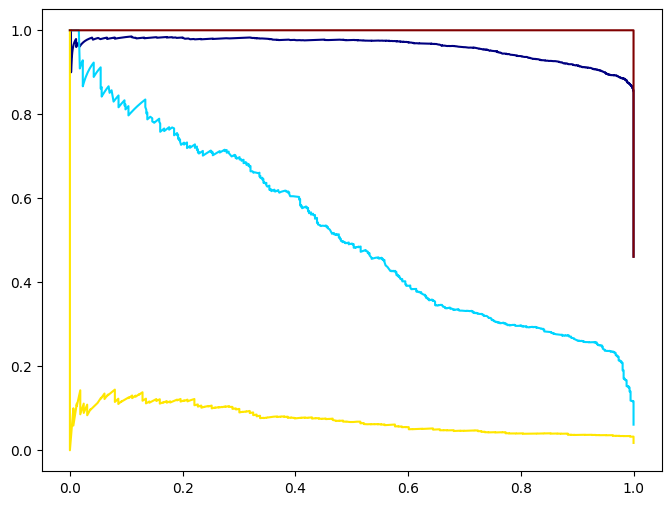

In [35]:
# --- Curva Precision-Recall ---
# Para multiclasse, a Precision-Recall Curve é tipicamente calculada One-vs-Rest (OvR).
# O `average_precision_score` no Scikit-learn pode calcular para multiclasse usando OvR.

print("\nCurvas Precision-Recall (One-vs-Rest):")
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.jet(np.linspace(0, 1, len(le.classes_)))

for i, class_label_original in enumerate(le.classes_):
    # Calcular y_true binário para a classe atual (1 se pertence à classe, 0 caso contrário)
    y_true_binary = (y_test == i).astype(int)
    # Obter as probabilidades para a classe atual
    y_scores_class = pipeline_final.predict_proba(X_test)[:, i]

    precision, recall, _ = precision_recall_curve(y_true_binary, y_scores_class)
    auc_pr = average_precision_score(y_true_binary, y_scores_class)

    ax.plot(recall, precision, color=colors[i],
            label=f'PRC para {class_label_original} (AUC = {auc_pr:.4f})')


In [36]:
ax.set_title('Precision-Recall Curve (One-vs-Rest)')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='lower left')
ax.grid(True)
plt.show()


Matriz de Confusão no conjunto de Teste:


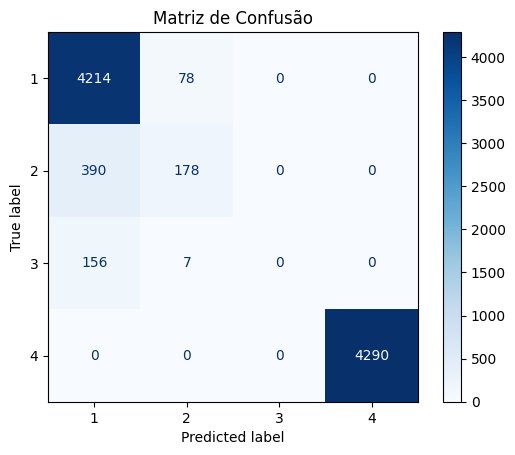

In [37]:
# --- Matriz de Confusão ---
print("\nMatriz de Confusão no conjunto de Teste:")
# labels=le.transform(le.classes_) garante a ordem correta dos rótulos
cm = confusion_matrix(y_test, y_pred, labels=le.transform(le.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

# --- Treinamento e Avaliação ---

In [38]:
print(df_modelo)

        FORMA CS_SEXO   CS_RACA            HIV     RAIOX_TORA BACILOSC_E  \
0         1.0       F     Parda  Não realizado            1.0        1.0   
1         1.0       M  Indígena   Não Reagente            4.0        1.0   
2         1.0       F     Parda  Não realizado            1.0        1.0   
3         1.0       M    Branca   Não Reagente            1.0        3.0   
4         1.0       M     Parda   Não Reagente            1.0        1.0   
...       ...     ...       ...            ...            ...        ...   
931294    4.0       M       2.0       Negativo         Normal   Negativo   
931295    4.0       F       5.0       Negativo  Não Realizado   Negativo   
931296    4.0       M       2.0       Negativo         Normal   Negativo   
931297    4.0       M       4.0       Negativo         Normal   Negativo   
931298    4.0       F       2.0       Negativo         Normal   Negativo   

       CULTURA_ES  NU_ANO  NU_IDADE_ANOS_CORRETA faixa_etaria  \
0             4.0    2

In [39]:
# --- SUGESTÃO PARA ACELERAR: Criar uma subamostra do conjunto de treino ---
# Usar uma fração dos dados para experimentação rápida.
# 0.2 significa usar 20% dos dados de treino. Ajuste conforme necessário.
print(f"Tamanho original de X_train: {len(X_train)}")

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=0.2, stratify=y_train, random_state=42
)

print(f"Tamanho da subamostra de X_train_sample: {len(X_train_sample)}")

# Agora, use X_train_sample e y_train_sample no cross_validate

Tamanho original de X_train: 912673
Tamanho da subamostra de X_train_sample: 182534
